## Assignment 7

The goal of this lab is to introduce the basic models used to simulate epidemics in networks, experiment with them and compare them. 
We will explore both types of diffusion models, decision-based and epidemic ones.
As a use case, we are going to use the coauthorship network of network scientists, which you can load with the function read gml from networkx library.

The following questions can be answered with the help of networkx and NDlib. You may also use other packages to deal with the problem. Please answer the following
questions on the networks you have and submit your executable code.

## Github Link: https://github.com/pariaighanian/Analysis_of_Complex_Netwroks/blob/main/Assignment_07.ipynb

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc
import random


In [2]:
#path = ""


In [103]:
# download a file from a url 
import requests

def download(url,file_name):
    get_response = requests.get(url)
    with open(file_name, "wb") as out_file:
        out_file.write(get_response.content)

#download(url = "http://www.casos.cs.cmu.edu/computational_tools/datasets/external/netscience/netscience.gml", file_name=path+"netscience.gml")
download(url = "http://www.casos.cs.cmu.edu/computational_tools/datasets/external/netscience/netscience.gml", file_name="netscience.gml")

In [3]:
# Read the data and show the basic information

file_name = "netscience.gml"
graph = nx.read_gml(file_name)

# Show basic information about the graph
print(nx.info(graph))

print("Nodes:", list(graph.nodes)[:10])  # Display first 10 nodes
print("Edges:", list(graph.edges)[:10])  # Display first 10 edges

Graph with 1589 nodes and 2742 edges
Nodes: ['ABRAMSON, G', 'KUPERMAN, M', 'ACEBRON, J', 'BONILLA, L', 'PEREZVICENTE, C', 'RITORT, F', 'SPIGLER, R', 'ADAMIC, L', 'ADAR, E', 'HUBERMAN, B']
Edges: [('ABRAMSON, G', 'KUPERMAN, M'), ('ABRAMSON, G', 'MORELLI, L'), ('KUPERMAN, M', 'ZANETTE, D'), ('KUPERMAN, M', 'MORELLI, L'), ('ACEBRON, J', 'BONILLA, L'), ('ACEBRON, J', 'PEREZVICENTE, C'), ('ACEBRON, J', 'RITORT, F'), ('ACEBRON, J', 'SPIGLER, R'), ('BONILLA, L', 'PEREZVICENTE, C'), ('BONILLA, L', 'RITORT, F')]


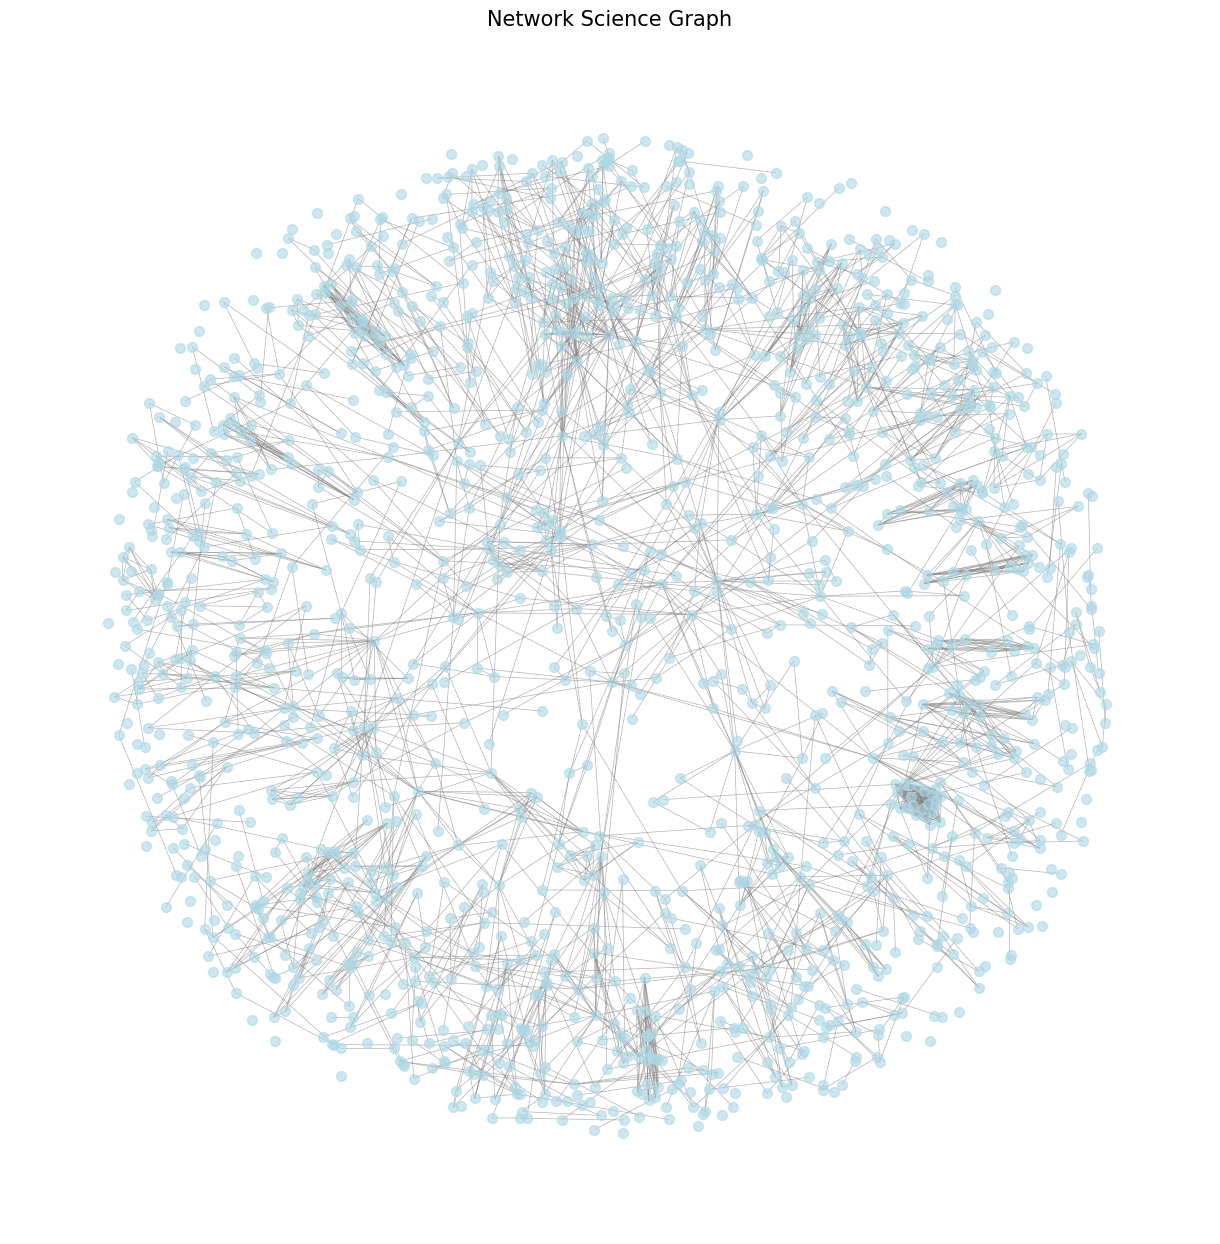

In [4]:
plt.figure(figsize=(12, 12))  

pos = nx.spring_layout(graph, seed=42, k=0.15) 

nx.draw(graph, pos, with_labels=False, node_size=50, font_size=10, font_color='black', 
        edge_color='gray', alpha=0.6, width=0.5, node_color='lightblue')

plt.title("Network Science Graph", fontsize=15)
plt.show()

**(a)** The Sznajd model is a variant of spin model based on social impact, which
takes into account the fact that a group of individuals with the same opinion can influence their
neighbours more than one single individual. Please use the Sznajd model to simulate the cascade
of misinformation between the network of network scientists for 100 steps with different initial ”infected” numbers: 100, 300, and 700. Please visualize the results and output a prevalence plot. (May refer to NDlib.)

In [5]:
def plot_diffusion_trend_and_prevalence(trends, num_iterations, total_nodes):
    # Initialize lists to track the number and fraction of nodes with each opinion
    pos_count_over_time = []
    neg_count_over_time = []
    
    for trend in trends:
        # Extract counts from each iteration's trend data
        pos_count = trend['trends']['node_count'][0]
        neg_count = trend['trends']['node_count'][1]

        # Append counts to track the evolution of opinions
        pos_count_over_time.append(pos_count)
        neg_count_over_time.append(neg_count)

    # Store fractions (for prevalence)
    pos_opinion_prevalence = [i / total_nodes for i in pos_count_over_time]
    neg_opinion_prevalence = [i / total_nodes for i in neg_count_over_time]

    # Create a figure with two subplots: one for Trend and one for Prevalence
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot Diffusion Trend (absolute pos_count)
    ax1.plot(range(num_iterations), pos_count_over_time, label="Positive Opinion (+1)", color='blue')
    ax1.plot(range(num_iterations), neg_count_over_time, label="Negative Opinion (-1)", color='red')
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Number of Nodes')
    ax1.set_title('Diffusion Trend: Opinion Dynamics')
    ax1.legend()

    # Plot Diffusion Prevalence (fractions)
    ax2.plot(range(num_iterations), pos_opinion_prevalence, label="Positive Opinion (+1)", color='blue')
    ax2.plot(range(num_iterations), neg_opinion_prevalence, label="Negative Opinion (-1)", color='red')
    ax2.set_xlabel('Iterations')
    ax2.set_ylabel('Prevalence (Fraction of Nodes)')
    ax2.set_title('Diffusion Prevalence: Opinion Dynamics')
    ax2.legend()

    # Show the combined plot
    plt.tight_layout()
    plt.show()


### sznajd_model: Reference https://en.wikipedia.org/wiki/Sznajd_model

### The Sznajd model simulates how opinions spread in a network. Each node represents an individual with a binary opinion: +1 (positive) or −1 (negative).

### Steps:
### 1. Initialization: Assign opinions to all nodes, with some starting as +1 (infected) and the rest as −1.
### 2. Propagation Rules: 
- Agreement: If two connected nodes agree, their neighbors adopt the same opinion. 
- Disagreement: If they disagree: Neighbors of the first node adopt the second node’s opinion. Neighbors of the second node adopt the first node’s opinion.
### 3. Iterations: Randomly pick edges and apply the rules over multiple steps.
### 4. Tracking and Visualization: Track the number of nodes with +1 and −1 opinions over time.
### 5. Plot the results to show opinion spread and prevalence.

In [6]:
def sznajd_model_extended(G, initial_infected_number, number_iterations, seed=None):
    """
    Simulate the extended Sznajd model with disagreement rules.
    
    Args:
        G: networkx graph
        initial_infected_number: Initial number of infected (nodes with positive opinion)
        number_iterations: Number of iterations for the simulation
        
    Returns:
        trends: A list of dictionaries tracking the number of nodes with each opinion at each iteration
    """
    # Set the random seed for reproducibility
    if seed is not None:
        random.seed(seed)
        
    # Initialize node opinions: +1 for infected, -1 for uninfected
    opinions = {node: -1 for node in G.nodes}
    initial_infected = random.sample(G.nodes, initial_infected_number)
    for node in initial_infected:
        opinions[node] = 1

    # Store trends over time
    trends = []

    for _ in range(number_iterations):
        # Randomly select an edge
        edge = random.choice(list(G.edges))
        u, v = edge

        # Get neighbors of u and v
        neighbors_u = set(G.neighbors(u)) - {v}
        neighbors_v = set(G.neighbors(v)) - {u}

        # Rule 1: If the pair agrees, their neighbors adopt the same opinion
        if opinions[u] == opinions[v]:
            for neighbor in neighbors_u | neighbors_v:
                opinions[neighbor] = opinions[u]

        # Rule 2: If the pair disagrees, neighbors adopt mixed opinions
        else:
            for neighbor in neighbors_u:
                opinions[neighbor] = opinions[v]  # Neighbor of u adopts opinion of v
            for neighbor in neighbors_v:
                opinions[neighbor] = opinions[u]  # Neighbor of v adopts opinion of u

        # Track the number of nodes with each opinion
        pos_count = sum(1 for opinion in opinions.values() if opinion == 1)
        neg_count = sum(1 for opinion in opinions.values() if opinion == -1)
        trends.append({'trends': {'node_count': [pos_count, neg_count]}})

    # Call the plot function to visualize the trend after the simulation
    plot_diffusion_trend_and_prevalence(trends, number_iterations, G.number_of_nodes())


C:\Users\35262\AppData\Local\Temp\ipykernel_35736\1932263952.py:19: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  initial_infected = random.sample(G.nodes, initial_infected_number)


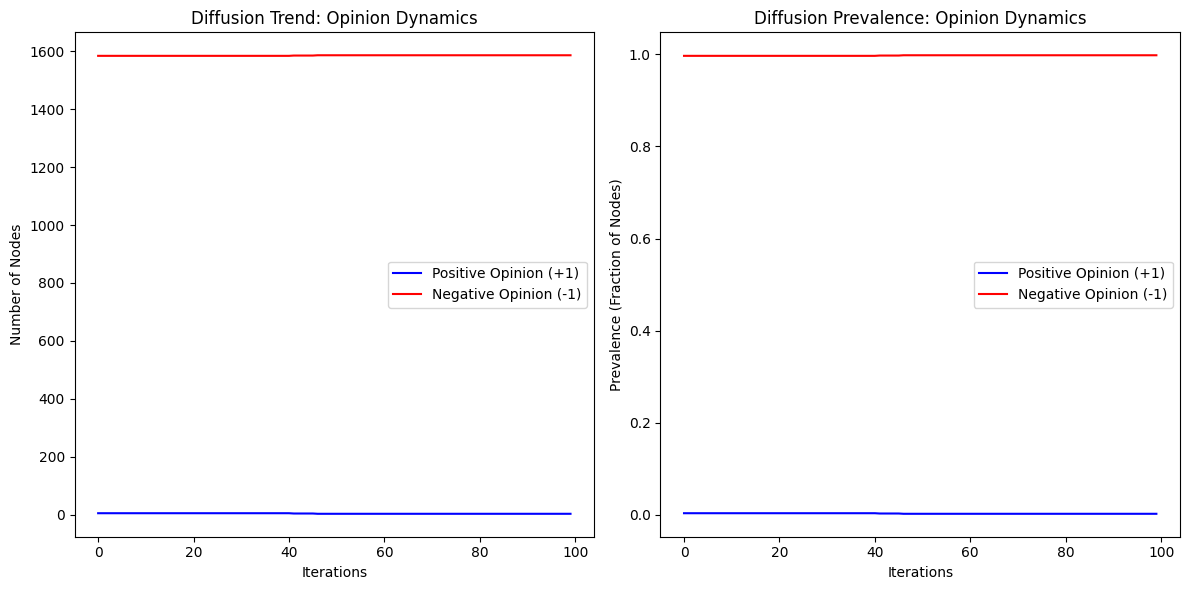

In [7]:
# Run sznajd for initial infected number: 5
sznajd_model_extended(graph, initial_infected_number=5, number_iterations=100, seed=42)

C:\Users\35262\AppData\Local\Temp\ipykernel_35736\1932263952.py:19: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  initial_infected = random.sample(G.nodes, initial_infected_number)


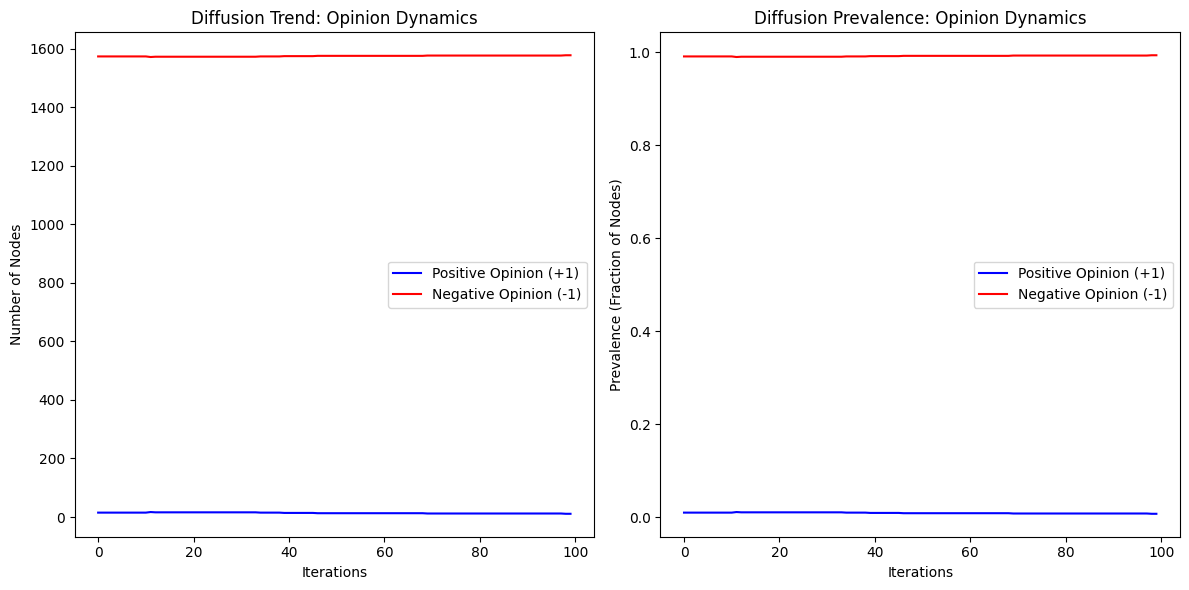

In [8]:
# Run sznajd for initial infected number: 15
sznajd_model_extended(graph, initial_infected_number=15, number_iterations=100, seed=42)

C:\Users\35262\AppData\Local\Temp\ipykernel_35736\1932263952.py:19: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  initial_infected = random.sample(G.nodes, initial_infected_number)


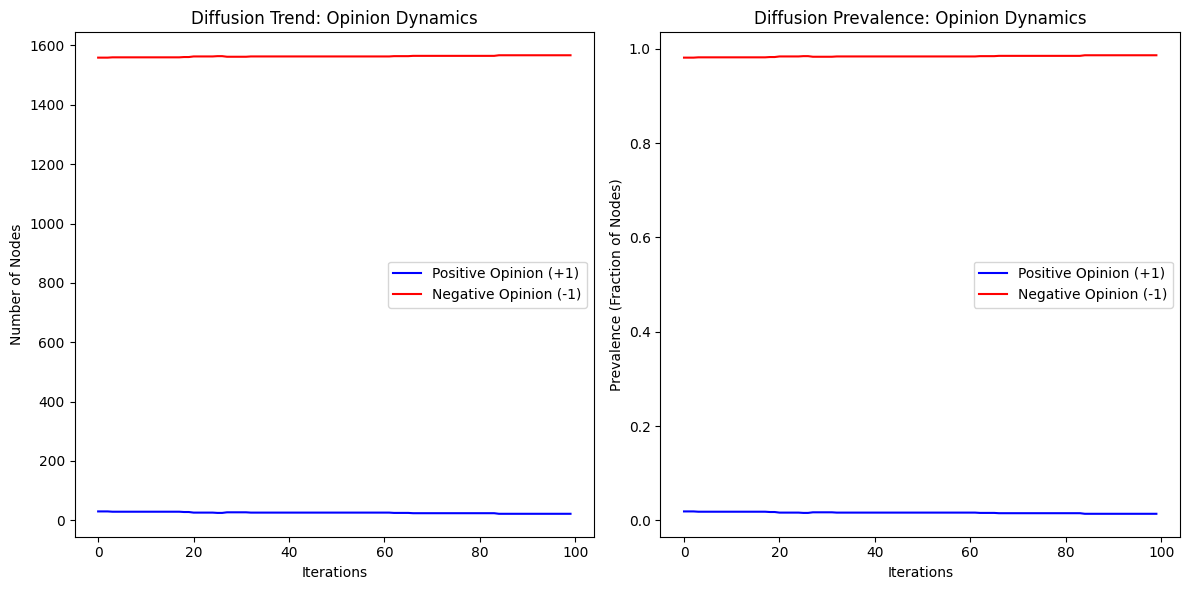

In [9]:
# Run sznajd for initial infected number: 30
sznajd_model_extended(graph, initial_infected_number=30, number_iterations=100, seed=42)

C:\Users\35262\AppData\Local\Temp\ipykernel_35736\1932263952.py:19: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  initial_infected = random.sample(G.nodes, initial_infected_number)


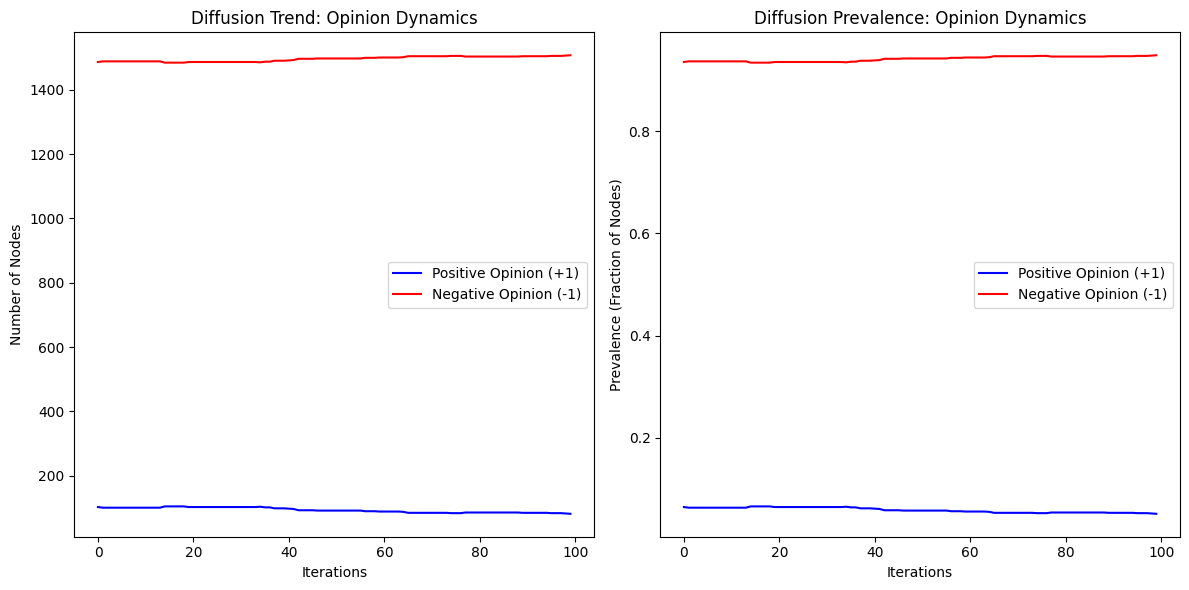

In [10]:
# Run sznajd for initial infected number: 100
sznajd_model_extended(graph, initial_infected_number=100, number_iterations=100, seed=42)

C:\Users\35262\AppData\Local\Temp\ipykernel_35736\1932263952.py:19: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  initial_infected = random.sample(G.nodes, initial_infected_number)


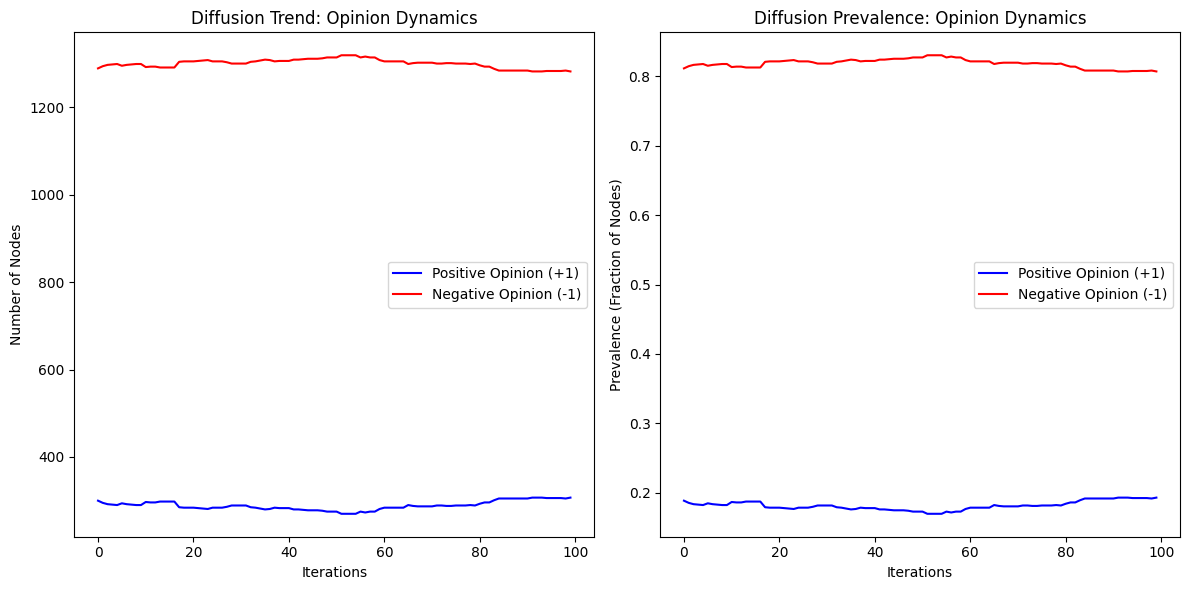

In [11]:
# Run sznajd for initial infected number: 300
sznajd_model_extended(graph, initial_infected_number=300, number_iterations=100, seed=42)

C:\Users\35262\AppData\Local\Temp\ipykernel_35736\1932263952.py:19: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  initial_infected = random.sample(G.nodes, initial_infected_number)


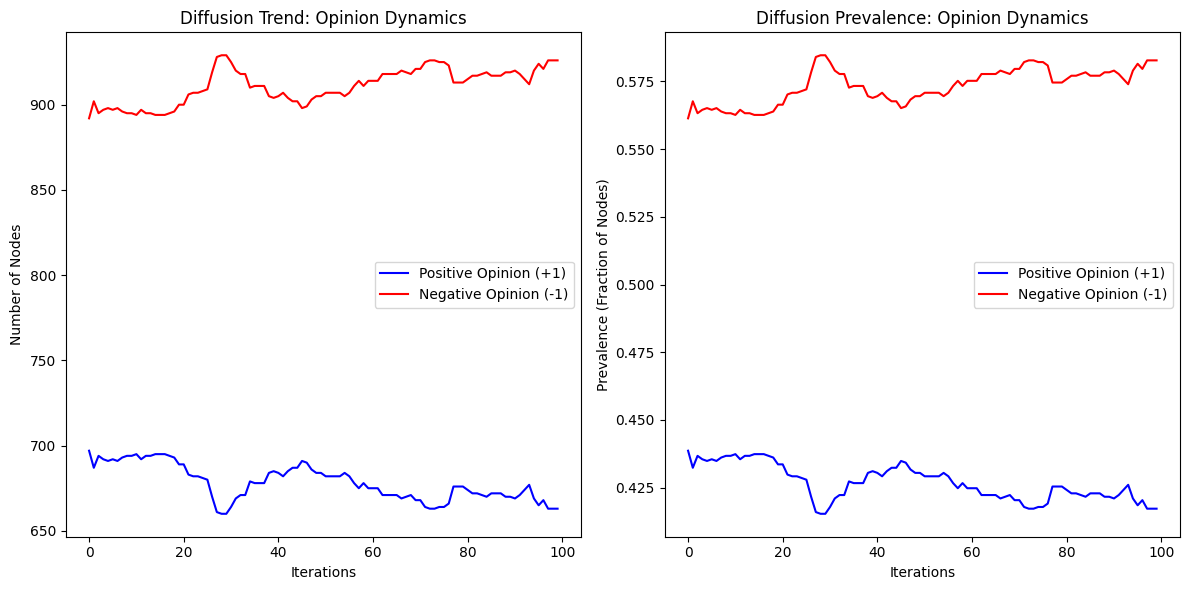

In [12]:
# Run sznajd for initial infected number: 700
sznajd_model_extended(graph, initial_infected_number=700, number_iterations=100, seed=42)

C:\Users\35262\AppData\Local\Temp\ipykernel_35736\1932263952.py:19: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  initial_infected = random.sample(G.nodes, initial_infected_number)


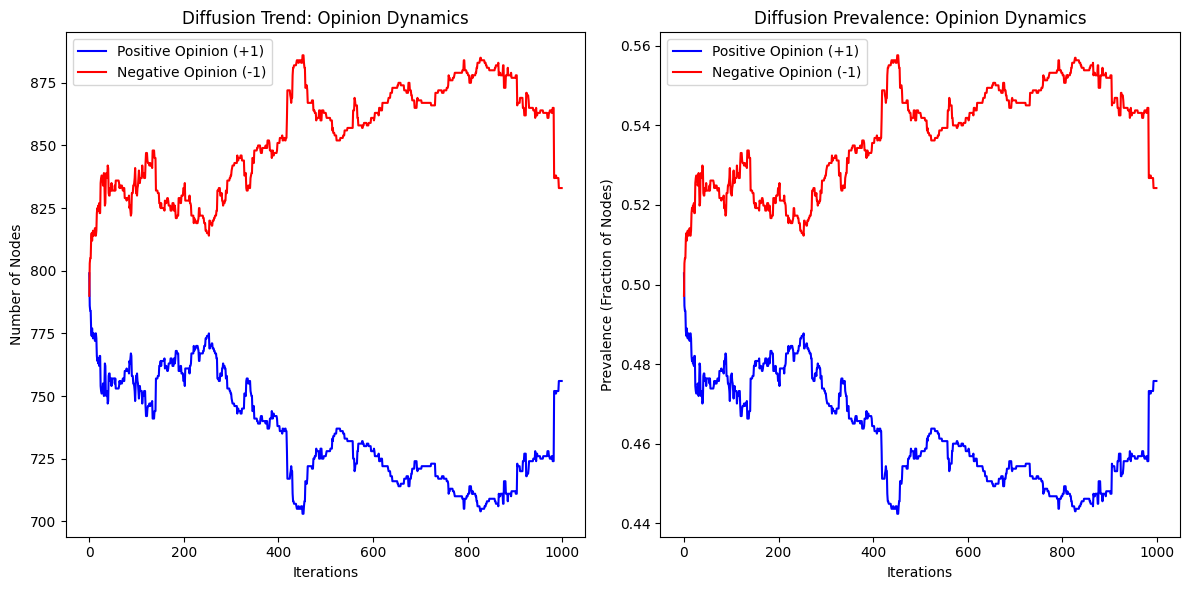

In [13]:
# Run sznajd for initial infected number: 800
sznajd_model_extended(graph, initial_infected_number=800, number_iterations=1000, seed=10)

**(b)** Although the interaction networks in real-life are different from the social networks we have, it is still meaningful to simulate the epidemics cascade with our dataset. The SIR model was introduced in 1927 by Kermack. In this model, during the course of an epidemic, a node is allowed to change its status from Susceptible (S) to Infected (I), then to Removed (R). Please use the SIR model to simulate for 100 iterations the cascade of the epidemic with the same number of initially infected nodes (suggested 0.5), with the following three sets of infection/removal probabilities: (0.5, 0.2), (0.3, 0.3), (0.4, 0.5) on the network science dataset, and visualize the results.

In [14]:
def SIR_model(
    G,
    ini_infect,
    infection,
    removal,
    num_iterations=100
):
    """
    Simulate the SIR model on a network and return the results.

    Args:
        G (networkx.Graph): A NetworkX graph.
        ini_infect (float): Initial fraction of infected nodes (0 to 1).
        infection (float): Infection probability (beta, 0 to 1).
        removal (float): Recovery/removal probability (gamma, 0 to 1).
        num_iterations (int): Number of iterations for the simulation.

    Returns:
        tuple: A tuple containing three lists:
            - susceptible_counts: List of counts of susceptible nodes over time.
            - infected_counts: List of counts of infected nodes over time.
            - removed_counts: List of counts of removed nodes over time.
    """
    # Declare the model
    model = ep.SIRModel(G)
    
    # Configure the model
    config = mc.Configuration()
    config.add_model_parameter("beta", infection)  # Infection probability
    config.add_model_parameter("gamma", removal)  # Recovery/removal probability
    config.add_model_parameter("fraction_infected", ini_infect)  # Initial fraction of infected nodes
    model.set_initial_status(config)
    
    # Execute the simulation
    iterations = model.iteration_bunch(num_iterations)
    
    # Extract trends for S, I, R
    susceptible_counts = [iteration["node_count"][0] for iteration in iterations]  # S: State 0
    infected_counts = [iteration["node_count"][1] for iteration in iterations]    # I: State 1
    removed_counts = [iteration["node_count"][2] for iteration in iterations]     # R: State 2

    return susceptible_counts, infected_counts, removed_counts


In [20]:
def plot_SIR(susceptible_counts, infected_counts, removed_counts, num_iterations, infection, removal):
    """
    Plot the SIR model results.
    
    Args:
        susceptible_counts (list[int]): List of counts of susceptible nodes over time.
        infected_counts (list[int]): List of counts of infected nodes over time.
        removed_counts (list[int]): List of counts of removed nodes over time.
        num_iterations (int): Number of iterations.
        infection (float): Infection probability (beta).
        removal (float): Recovery/removal probability (gamma).
    """
    plt.figure(figsize=(10, 6))
    plt.plot(range(num_iterations), susceptible_counts, label="Susceptible (S)", color="blue")
    plt.plot(range(num_iterations), infected_counts, label="Infected (I)", color="red")
    plt.plot(range(num_iterations), removed_counts, label="Removed (R)", color="green")

    plt.title(f"SIR Model Simulation (β={infection}, γ={removal})")
    plt.xlabel("Iterations")
    plt.ylabel("Number of Nodes")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Right center

    plt.grid(True)
    plt.tight_layout()
    plt.show()


Running SIR model simulation with β=0.5 and γ=0.2


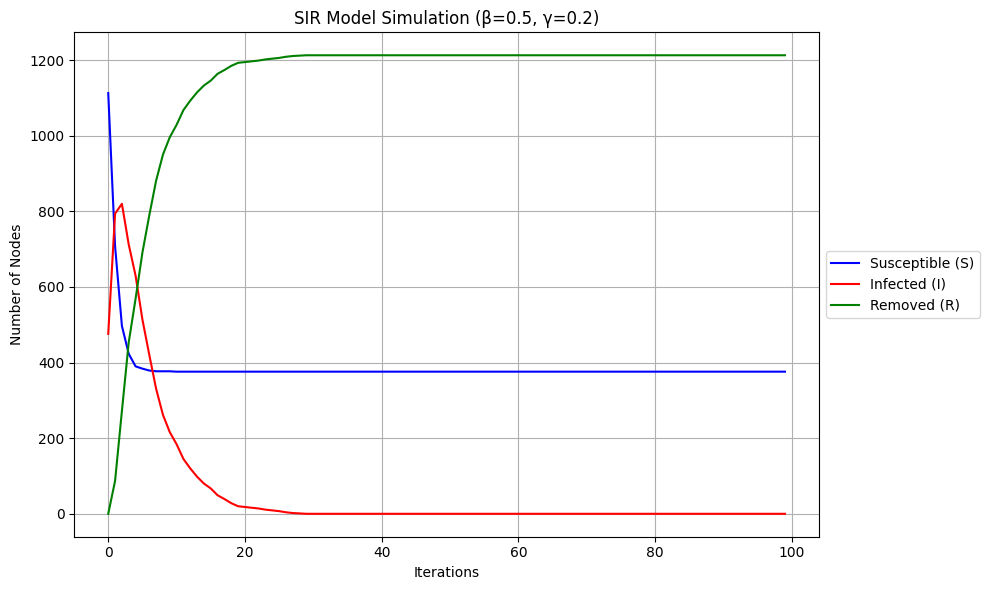

In [21]:
print("Running SIR model simulation with β=0.5 and γ=0.2")
susceptible, infected, removed = SIR_model(
    G=graph,        # Your network graph
    ini_infect=0.3, # 30% of nodes initially infected
    infection=0.5,  # Infection probability
    removal=0.2,    # Recovery/removal probability
    num_iterations=100
)

# Plot the results
plot_SIR(
    susceptible_counts=susceptible,
    infected_counts=infected,
    removed_counts=removed,
    num_iterations=100,
    infection=0.5,
    removal=0.2
)

Running SIR model simulation with β=0.3 and γ=0.3


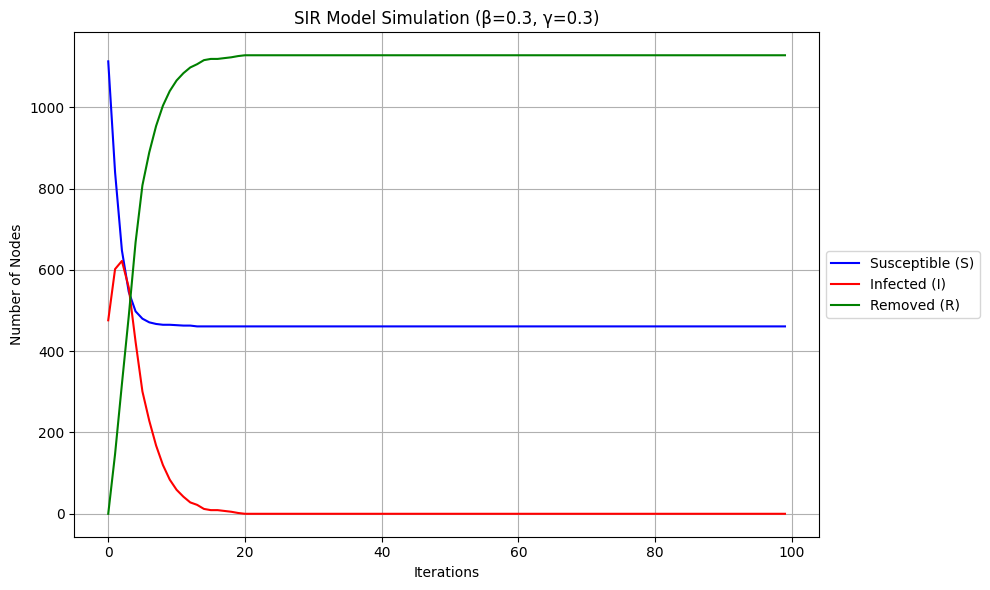

In [22]:
print("Running SIR model simulation with β=0.3 and γ=0.3")
susceptible, infected, removed = SIR_model(
    G=graph,        # Your network graph
    ini_infect=0.3, # 30% of nodes initially infected
    infection=0.3,  # Infection probability
    removal=0.3,    # Recovery/removal probability
    num_iterations=100
)

# Plot the results
plot_SIR(
    susceptible_counts=susceptible,
    infected_counts=infected,
    removed_counts=removed,
    num_iterations=100,
    infection=0.3,
    removal=0.3
)

Running SIR model simulation with β=0.4 and γ=0.5


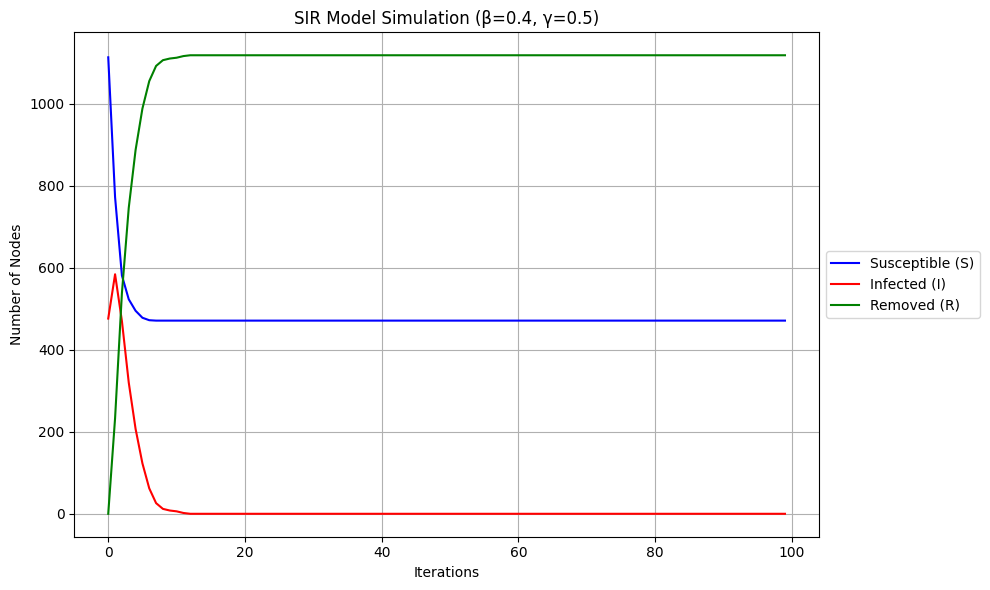

In [25]:
print("Running SIR model simulation with β=0.4 and γ=0.5")
susceptible, infected, removed = SIR_model(
    G=graph,        # Your network graph
    ini_infect=0.3, # 30% of nodes initially infected
    infection=0.4,  # Infection probability
    removal=0.5,    # Recovery/removal probability
    num_iterations=100
)

# Plot the results
plot_SIR(
    susceptible_counts=susceptible,
    infected_counts=infected,
    removed_counts=removed,
    num_iterations=100,
    infection=0.4,
    removal=0.5
)